In [1]:
#I like my cells wide and proud
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#### Review the resources landscape:
```
!nvidia-smi
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
```

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from six.moves import xrange
import logging
import os
###########################
from cleverhans.attacks import CarliniWagnerL2
from cleverhans.utils import pair_visual, grid_visual, AccuracyReport
from cleverhans.utils import set_log_level
from cleverhans.utils_mnist import data_mnist
#(Vishal) removed model_test (doesn't exist)
from cleverhans.utils_tf import model_eval, tf_model_load
from cleverhans_tutorials.tutorial_models import make_basic_cnn
########### keras ############
from cleverhans.utils_keras import cnn_model as cnn_keras
from cleverhans.utils_keras import KerasModelWrapper

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import tensorflow as tf
print(tf.__version__)
import cleverhans
cleverhans.__version__

1.4.1


'2.0.0-ec369c6c75289a3d778f69cbee8f1eb5'

# Initialize the parameters as per:
https://github.com/tensorflow/cleverhans/blob/b8d15f3d7b6f820f812087512b60d9675cb431eb/cleverhans_tutorials/mnist_tutorial_cw.py

In [4]:
#     :param train_start: index of first training set example
#     :param train_end: index of last training set example
#     :param test_start: index of first test set example
#     :param test_end: index of last test set example
#     :param viz_enabled: (boolean) activate plots of adversarial examples
#     :param nb_epochs: number of epochs to train model
#     :param batch_size: size of training batches
#     :param nb_classes: number of output classes
#     :param source_samples: number of test inputs to attack
#     :param learning_rate: learning rate for training
#     :param model_path: path to the model file
#     :param targeted: should we run a targeted attack? or untargeted?
train_start=0
train_end=60000
test_start=0
test_end=10000
viz_enabled=True
nb_epochs=6
batch_size=128
nb_classes=10
source_samples=10
learning_rate=0.001
attack_iterations=100
#(Vishal) Trained model in link to obtain pretrained model
model_path=os.path.join("keras_models", "mnist")
targeted=True
# Object used to keep track of (and return) key accuracies
report = AccuracyReport()

# Model definition:

In [5]:
# MNIST-specific dimensions
img_rows = 28
img_cols = 28
channels = 1

# Set TF random seed to improve reproducibility
tf.set_random_seed(1234)

# # Create TF session
# tf.device("/gpu:0")
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
#(Vishal) Commented out since running on local machine without gpus
#sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=.666), device_count={'CPU':2, 'GPU':0}))

sess=tf.Session()
print("Created TensorFlow session.")
import keras
from keras import backend as K
K.set_session(sess)
set_log_level(logging.DEBUG)

# Get MNIST test data
X_test, Y_test, X_test, Y_test = data_mnist(train_start=train_start,
                                              train_end=train_end,
                                              test_start=test_start,
                                              test_end=test_end)


# Define input TF placeholder
x = tf.placeholder(tf.float32, shape=(None, img_rows, img_cols, channels))
y = tf.placeholder(tf.float32, shape=(None, nb_classes))

#################################################################################
"""
def make_basic_cnn(nb_filters=64, nb_classes=10,input_shape=(None, 28, 28, 1)):
    layers = [Conv2D(nb_filters, (8, 8), (2, 2), "SAME"),
              ReLU(),
              Conv2D(nb_filters * 2, (6, 6), (2, 2), "VALID"),
              ReLU(),
              Conv2D(nb_filters * 2, (5, 5), (1, 1), "VALID"),
              ReLU(),
              Flatten(),
              Linear(nb_classes),
              Softmax()]

    model = MLP(layers, input_shape)
    return model
"""
##################################################################################
"""
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

nb_filters=64
model = Sequential()
model.add(Conv2D(nb_filters, kernel_size=(8, 8),strides=(2,2),padding="same",activation='relu',
                 input_shape=(img_rows, img_cols,channels)))
model.add(Conv2D(nb_filters*2, kernel_size=(6, 6),strides=(2,2),padding="valid",activation='relu'))
model.add(Conv2D(nb_filters*2, kernel_size=(5, 5),strides=(1,1),padding="valid",activation='relu'))
model.add(Flatten())
model.add(Dense(nb_classes, activation='softmax'))
"""
#model=make_basic_cnn()
#(Vishal) Decided to use cnn_keras since it works with the keras wrapper from cleverhans
model=cnn_keras()
##################################################################################
preds = model(x)
print("Not yet Defined TensorFlow model graph.")


Created TensorFlow session.
Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)
Not yet Defined TensorFlow model graph.


In [6]:
print(model_path)
print(os.path.exists(model_path + ".meta"))

rng = np.random.RandomState([2017, 11, 3])
# check if we've trained before, and if we have, use that pre-trained model
if os.path.exists(model_path + ".meta"):
    print('Loading the pre-trained Keras model')
    tf_model_load(sess, model_path)


keras_models/mnist
True
Loading the pre-trained Keras model
INFO:tensorflow:Restoring parameters from keras_models/mnist


###########################################################################
# Testing the loaded model using TensorFlow
###########################################################################

In [7]:
# Evaluate the accuracy of the MNIST model on legitimate test examples

eval_params = {'batch_size': 128}
accuracy = model_eval(sess, x, y, preds, X_test, Y_test, args=eval_params)
assert X_test.shape[0] == test_end - test_start, X_test.shape
print('Test accuracy on legitimate test examples: {0}'.format(accuracy))
report.clean_test_clean_eval = accuracy

Test accuracy on legitimate test examples: 0.9878


In [8]:
#(Vishal) weights not saved so not required
#model.load_weights('mnist_9868.h5')
model.predict_classes(X_test[0:6,:,:,:])

array([7, 2, 1, 0, 4, 1])

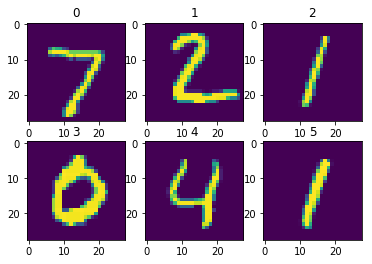

In [9]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X_test[i,:,:,0])
    plt.title(str(i))

# Let's pick 10 legit examples to target:

Crafting 10 * 9 adversarial examples


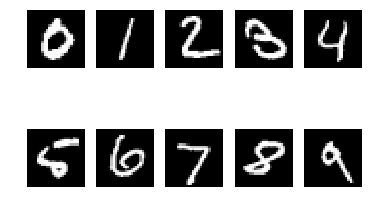

In [10]:
nb_adv_per_sample = str(nb_classes - 1)
print('Crafting ' + str(source_samples) + ' * ' + nb_adv_per_sample + ' adversarial examples')
###########################################################################

assert source_samples == nb_classes
idxs = [np.where(np.argmax(Y_test, axis=1) == i)[0][0] for i in range(nb_classes)]
# [3, 2, 1, 18, 4, 8, 11, 0, 61, 7]
# Pick the first appearances of the 9 numbers in X_test
for i,idx in enumerate(idxs):
    plt.subplot(2,5,i+1)
    plt.imshow(X_test[idx,:,:,0],cmap='gray')
    plt.axis('off')


# Create adv samples using the Carlini-L2 attack:

In [11]:
# Form a 10 x 10 array of the inputs that you seek to target:
adv_inputs = np.array([[instance] * nb_classes for instance in X_test[idxs]],dtype=np.float32)
adv_inputs = adv_inputs.reshape((source_samples * nb_classes, img_rows, img_cols, 1))


one_hot = np.zeros((nb_classes, nb_classes))
one_hot[np.arange(nb_classes), np.arange(nb_classes)] = 1



adv_ys = np.array([one_hot] * source_samples,dtype=np.float32).reshape((source_samples * nb_classes, nb_classes))
# yname = "y_target"
# Instantiate a CW attack object
#model1 = KerasModelWrapper(model)
#(Vishal) model passed into CarliniWagner must be of type Model (as defined) so we pass our keras model to the KerasModelWrapper
model_wrap=KerasModelWrapper(model)
cw = CarliniWagnerL2(model_wrap, back='tf', sess=sess)
#(Vishal) Changed binary_search_steps and max_iterations to test if the code runs (takes too long for original values)
cw_params = {'binary_search_steps': 1,#15,
             'y_target': adv_ys,
             'max_iterations': 100,#50000,
             'learning_rate': 1.5,
             'batch_size': source_samples * nb_classes if
             targeted else source_samples,
             'initial_const': 1,}

adv = cw.generate_np(adv_inputs, **cw_params)

[INFO 2018-02-18 20:43:01,979 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-02-18 20:43:03,813 cleverhans] Running CWL2 attack on instance 0 of 100
[DEBUG 2018-02-18 20:43:03,830 cleverhans]   Binary search step 0 of 1
[DEBUG 2018-02-18 20:43:04,320 cleverhans]     Iteration 0 of 100: loss=1.67e+03 l2=0 f=0.1
[DEBUG 2018-02-18 20:43:08,170 cleverhans]     Iteration 10 of 100: loss=1.21e+03 l2=8.91 f=0.0412
[DEBUG 2018-02-18 20:43:12,130 cleverhans]     Iteration 20 of 100: loss=1.09e+03 l2=8.78 f=0.0329
[DEBUG 2018-02-18 20:43:16,223 cleverhans]     Iteration 30 of 100: loss=1.03e+03 l2=8.57 f=0.0279
[DEBUG 2018-02-18 20:43:19,978 cleverhans]     Iteration 40 of 100: loss=1e+03 l2=8.36 f=0.0236
[DEBUG 2018-02-18 20:43:23,879 cleverhans]     Iteration 50 of 100: loss=983 l2=8.34 f=0.0167
[DEBUG 2018-02-18 20:43:27,636 cleverhans]     Iteration 60 of 100: loss=979 l2=8.14 f=0.0248
[DEBUG 2018-02-18 20:43:31,422 cleverhans]     Iteration 70 of 100: loss=967 l2=

Text(0,0.5,'Matrix norm dist b/w adv and input image')

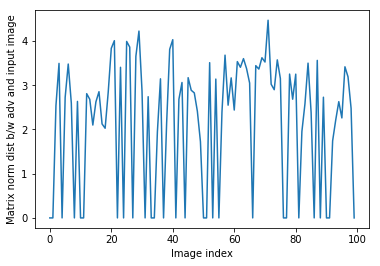

In [12]:
dev=np.zeros(100)
for i in range(100):
    dev[i]=np.linalg.norm(np.abs(adv[i,:,:,0]-adv_inputs[i,:,:,0]))
plt.plot(dev)
plt.xlabel('Image index')
plt.ylabel('Matrix norm dist b/w adv and input image')

In [13]:
np.mod(np.where(dev>0.1)[0],10)

array([2, 3, 5, 6, 7, 9, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 3, 5, 6, 8, 9, 0,
       2, 5, 6, 8, 9, 0, 2, 3, 5, 6, 7, 8, 9, 2, 4, 6, 7, 8, 9, 0, 1, 2,
       3, 4, 5, 7, 8, 9, 0, 1, 2, 3, 4, 5, 8, 9, 0, 2, 3, 4, 5, 7, 9, 2,
       3, 4, 5, 6, 7, 8])

In [14]:
model.predict_classes(adv[np.where(dev>0.1)[0]])

array([2, 3, 5, 6, 7, 9, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 3, 5, 6, 8, 9, 0,
       2, 5, 6, 8, 9, 0, 2, 3, 5, 6, 7, 8, 9, 2, 4, 6, 7, 8, 9, 0, 1, 2,
       3, 4, 5, 7, 8, 9, 0, 1, 2, 3, 4, 5, 8, 9, 0, 2, 3, 4, 5, 7, 9, 2,
       3, 4, 5, 6, 7, 8])

In [15]:
np.save('adv_cw_targeted49_model9868.npy',adv)

# Non-targeted:

In [16]:
np.where(dev>0.1)[0]
y_test=np.where(Y_test==1)[1]
adv_inputs=np.zeros((100,28,28,1))
for i in range(10):
    ind_i=np.where(y_test==i)[0][0:10]
    adv_inputs[10*i:10*i+10,:,:,:]=X_test[ind_i]
#model_wrap=KerasModelWrapper(model)
#(Vishal) model_wrap is from the previous model
cw = CarliniWagnerL2(model_wrap, back='tf', sess=sess)
#(Vishal) Changed max_iterations to test if the code runs (takes too long for original values)
cw_params = {'binary_search_steps': 10,
             'y_target': None,
             'max_iterations':100,#10000,
             'learning_rate': 2,
             'batch_size':source_samples,
             'initial_const': 50,
            'clip_min' :0,
            'clip_max':1}

adv_nt = cw.generate_np(adv_inputs, **cw_params)

[INFO 2018-02-18 20:43:35,865 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-02-18 20:43:37,864 cleverhans] Running CWL2 attack on instance 0 of 100
[DEBUG 2018-02-18 20:43:37,879 cleverhans]   Binary search step 0 of 10
[DEBUG 2018-02-18 20:43:38,067 cleverhans]     Iteration 0 of 100: loss=7.26e+03 l2=0 f=-0.047
[DEBUG 2018-02-18 20:43:38,435 cleverhans]     Iteration 10 of 100: loss=578 l2=57.8 f=-0.0907
[DEBUG 2018-02-18 20:43:38,813 cleverhans]     Iteration 20 of 100: loss=569 l2=56.9 f=-0.117
[DEBUG 2018-02-18 20:43:39,210 cleverhans]     Iteration 30 of 100: loss=566 l2=56.6 f=-0.117
[DEBUG 2018-02-18 20:43:39,578 cleverhans]     Iteration 40 of 100: loss=565 l2=56.5 f=-0.112
[DEBUG 2018-02-18 20:43:39,953 cleverhans]     Iteration 50 of 100: loss=564 l2=56.4 f=-0.113
[DEBUG 2018-02-18 20:43:40,339 cleverhans]     Iteration 60 of 100: loss=562 l2=56.2 f=-0.119
[DEBUG 2018-02-18 20:43:40,716 cleverhans]     Iteration 70 of 100: loss=560 l2=56 f=-0.119


[DEBUG 2018-02-18 20:43:53,065 cleverhans] Running CWL2 attack on instance 10 of 100
[DEBUG 2018-02-18 20:43:53,067 cleverhans]   Binary search step 0 of 10
[DEBUG 2018-02-18 20:43:53,112 cleverhans]     Iteration 0 of 100: loss=5.77e+03 l2=0 f=-1.12
[DEBUG 2018-02-18 20:43:53,530 cleverhans]     Iteration 10 of 100: loss=338 l2=33.8 f=-0.186
[DEBUG 2018-02-18 20:43:53,933 cleverhans]     Iteration 20 of 100: loss=321 l2=32.1 f=-0.233
[DEBUG 2018-02-18 20:43:54,362 cleverhans]     Iteration 30 of 100: loss=318 l2=31.8 f=-0.234
[DEBUG 2018-02-18 20:43:54,756 cleverhans]     Iteration 40 of 100: loss=318 l2=31.8 f=-0.233
[DEBUG 2018-02-18 20:43:54,757 cleverhans]     Failed to make progress; stop early
[DEBUG 2018-02-18 20:43:54,760 cleverhans]   Successfully generated adversarial examples on 10 of 10 instances.
[DEBUG 2018-02-18 20:43:54,762 cleverhans]    Mean successful distortion: 4.723
[DEBUG 2018-02-18 20:43:54,764 cleverhans]   Binary search step 1 of 10
[DEBUG 2018-02-18 20:43:54

[DEBUG 2018-02-18 20:44:09,351 cleverhans]     Failed to make progress; stop early
[DEBUG 2018-02-18 20:44:09,352 cleverhans]   Successfully generated adversarial examples on 10 of 10 instances.
[DEBUG 2018-02-18 20:44:09,354 cleverhans]    Mean successful distortion: 6.34
[DEBUG 2018-02-18 20:44:09,356 cleverhans]   Binary search step 1 of 10
[DEBUG 2018-02-18 20:44:09,409 cleverhans]     Iteration 0 of 100: loss=3.7e+03 l2=0 f=0.0132
[DEBUG 2018-02-18 20:44:09,796 cleverhans]     Iteration 10 of 100: loss=422 l2=42.2 f=-0.0386
[DEBUG 2018-02-18 20:44:10,200 cleverhans]     Iteration 20 of 100: loss=409 l2=40.9 f=-0.0238
[DEBUG 2018-02-18 20:44:10,604 cleverhans]     Iteration 30 of 100: loss=403 l2=40.3 f=-0.0306
[DEBUG 2018-02-18 20:44:11,007 cleverhans]     Iteration 40 of 100: loss=402 l2=40.2 f=-0.0384
[DEBUG 2018-02-18 20:44:11,423 cleverhans]     Iteration 50 of 100: loss=402 l2=40.2 f=-0.0389
[DEBUG 2018-02-18 20:44:11,813 cleverhans]     Iteration 60 of 100: loss=399 l2=39.9 

[DEBUG 2018-02-18 20:44:26,867 cleverhans]    Mean successful distortion: 5.538
[DEBUG 2018-02-18 20:44:26,869 cleverhans]   Binary search step 1 of 10
[DEBUG 2018-02-18 20:44:26,908 cleverhans]     Iteration 0 of 100: loss=3.04e+03 l2=0 f=-0.177
[DEBUG 2018-02-18 20:44:27,312 cleverhans]     Iteration 10 of 100: loss=298 l2=29.8 f=-0.186
[DEBUG 2018-02-18 20:44:27,681 cleverhans]     Iteration 20 of 100: loss=275 l2=27.5 f=-0.205
[DEBUG 2018-02-18 20:44:28,066 cleverhans]     Iteration 30 of 100: loss=273 l2=27.1 f=-0.205
[DEBUG 2018-02-18 20:44:28,475 cleverhans]     Iteration 40 of 100: loss=269 l2=26.9 f=-0.203
[DEBUG 2018-02-18 20:44:28,870 cleverhans]     Iteration 50 of 100: loss=268 l2=26.8 f=-0.203
[DEBUG 2018-02-18 20:44:29,272 cleverhans]     Iteration 60 of 100: loss=268 l2=26.8 f=-0.195
[DEBUG 2018-02-18 20:44:29,273 cleverhans]     Failed to make progress; stop early
[DEBUG 2018-02-18 20:44:29,275 cleverhans]   Successfully generated adversarial examples on 10 of 10 insta

[DEBUG 2018-02-18 20:44:41,162 cleverhans]     Iteration 10 of 100: loss=209 l2=20.8 f=-0.092
[DEBUG 2018-02-18 20:44:41,564 cleverhans]     Iteration 20 of 100: loss=208 l2=20.8 f=-0.00415
[DEBUG 2018-02-18 20:44:41,970 cleverhans]     Iteration 30 of 100: loss=202 l2=20.2 f=-0.0651
[DEBUG 2018-02-18 20:44:42,366 cleverhans]     Iteration 40 of 100: loss=199 l2=19.9 f=-0.0754
[DEBUG 2018-02-18 20:44:42,805 cleverhans]     Iteration 50 of 100: loss=202 l2=20.2 f=-0.0384
[DEBUG 2018-02-18 20:44:42,807 cleverhans]     Failed to make progress; stop early
[DEBUG 2018-02-18 20:44:42,808 cleverhans]   Successfully generated adversarial examples on 10 of 10 instances.
[DEBUG 2018-02-18 20:44:42,810 cleverhans]    Mean successful distortion: 4.433
[DEBUG 2018-02-18 20:44:42,812 cleverhans]   Binary search step 3 of 10
[DEBUG 2018-02-18 20:44:42,847 cleverhans]     Iteration 0 of 100: loss=689 l2=0 f=-0.48
[DEBUG 2018-02-18 20:44:43,288 cleverhans]     Iteration 10 of 100: loss=178 l2=17.8 f=-0

[DEBUG 2018-02-18 20:44:56,392 cleverhans]   Binary search step 3 of 10
[DEBUG 2018-02-18 20:44:56,434 cleverhans]     Iteration 0 of 100: loss=870 l2=0 f=-0.278
[DEBUG 2018-02-18 20:44:56,832 cleverhans]     Iteration 10 of 100: loss=265 l2=26.3 f=-0.164
[DEBUG 2018-02-18 20:44:57,223 cleverhans]     Iteration 20 of 100: loss=255 l2=25.5 f=-0.164
[DEBUG 2018-02-18 20:44:57,658 cleverhans]     Iteration 30 of 100: loss=252 l2=25.2 f=-0.163
[DEBUG 2018-02-18 20:44:58,068 cleverhans]     Iteration 40 of 100: loss=253 l2=25 f=-0.165
[DEBUG 2018-02-18 20:44:58,069 cleverhans]     Failed to make progress; stop early
[DEBUG 2018-02-18 20:44:58,070 cleverhans]   Successfully generated adversarial examples on 10 of 10 instances.
[DEBUG 2018-02-18 20:44:58,072 cleverhans]    Mean successful distortion: 4.907
[DEBUG 2018-02-18 20:44:58,076 cleverhans]   Binary search step 4 of 10
[DEBUG 2018-02-18 20:44:58,118 cleverhans]     Iteration 0 of 100: loss=435 l2=0 f=-0.278
[DEBUG 2018-02-18 20:44:58,

[DEBUG 2018-02-18 20:45:11,650 cleverhans]     Iteration 0 of 100: loss=375 l2=0 f=0.692
[DEBUG 2018-02-18 20:45:12,097 cleverhans]     Iteration 10 of 100: loss=160 l2=16 f=0.258
[DEBUG 2018-02-18 20:45:12,507 cleverhans]     Iteration 20 of 100: loss=158 l2=15.2 f=0.297
[DEBUG 2018-02-18 20:45:12,959 cleverhans]     Iteration 30 of 100: loss=156 l2=15.3 f=0.262
[DEBUG 2018-02-18 20:45:13,427 cleverhans]     Iteration 40 of 100: loss=151 l2=15.1 f=0.268
[DEBUG 2018-02-18 20:45:13,882 cleverhans]     Iteration 50 of 100: loss=150 l2=14.5 f=0.298
[DEBUG 2018-02-18 20:45:14,339 cleverhans]     Iteration 60 of 100: loss=153 l2=14.9 f=0.278
[DEBUG 2018-02-18 20:45:14,341 cleverhans]     Failed to make progress; stop early
[DEBUG 2018-02-18 20:45:14,342 cleverhans]   Successfully generated adversarial examples on 10 of 10 instances.
[DEBUG 2018-02-18 20:45:14,344 cleverhans]    Mean successful distortion: 3.753
[DEBUG 2018-02-18 20:45:14,347 cleverhans]   Binary search step 5 of 10
[DEBUG 2

[DEBUG 2018-02-18 20:45:35,954 cleverhans]    Mean successful distortion: 5.141
[DEBUG 2018-02-18 20:45:35,957 cleverhans]   Binary search step 4 of 10
[DEBUG 2018-02-18 20:45:36,005 cleverhans]     Iteration 0 of 100: loss=446 l2=0 f=-0.0867
[DEBUG 2018-02-18 20:45:36,816 cleverhans]     Iteration 10 of 100: loss=224 l2=21.6 f=-0.327
[DEBUG 2018-02-18 20:45:37,538 cleverhans]     Iteration 20 of 100: loss=204 l2=20.4 f=-0.292
[DEBUG 2018-02-18 20:45:38,238 cleverhans]     Iteration 30 of 100: loss=206 l2=20.4 f=-0.279
[DEBUG 2018-02-18 20:45:38,240 cleverhans]     Failed to make progress; stop early
[DEBUG 2018-02-18 20:45:38,241 cleverhans]   Successfully generated adversarial examples on 10 of 10 instances.
[DEBUG 2018-02-18 20:45:38,243 cleverhans]    Mean successful distortion: 4.346
[DEBUG 2018-02-18 20:45:38,246 cleverhans]   Binary search step 5 of 10
[DEBUG 2018-02-18 20:45:38,353 cleverhans]     Iteration 0 of 100: loss=223 l2=0 f=-0.0867
[DEBUG 2018-02-18 20:45:38,946 clever

[DEBUG 2018-02-18 20:46:05,447 cleverhans]     Iteration 0 of 100: loss=381 l2=0 f=-0.298
[DEBUG 2018-02-18 20:46:06,007 cleverhans]     Iteration 10 of 100: loss=151 l2=14.9 f=-0.327
[DEBUG 2018-02-18 20:46:06,810 cleverhans]     Iteration 20 of 100: loss=145 l2=14.3 f=-0.319
[DEBUG 2018-02-18 20:46:07,590 cleverhans]     Iteration 30 of 100: loss=143 l2=14.1 f=-0.334
[DEBUG 2018-02-18 20:46:08,327 cleverhans]     Iteration 40 of 100: loss=140 l2=14 f=-0.326
[DEBUG 2018-02-18 20:46:09,151 cleverhans]     Iteration 50 of 100: loss=141 l2=14.1 f=-0.324
[DEBUG 2018-02-18 20:46:09,152 cleverhans]     Failed to make progress; stop early
[DEBUG 2018-02-18 20:46:09,154 cleverhans]   Successfully generated adversarial examples on 10 of 10 instances.
[DEBUG 2018-02-18 20:46:09,155 cleverhans]    Mean successful distortion: 3.698
[DEBUG 2018-02-18 20:46:09,157 cleverhans]   Binary search step 5 of 10
[DEBUG 2018-02-18 20:46:09,243 cleverhans]     Iteration 0 of 100: loss=191 l2=0 f=-0.298
[DEBU

[DEBUG 2018-02-18 20:46:38,538 cleverhans]     Iteration 0 of 100: loss=235 l2=0 f=0.116
[DEBUG 2018-02-18 20:46:39,325 cleverhans]     Iteration 10 of 100: loss=124 l2=12.1 f=0.0218
[DEBUG 2018-02-18 20:46:40,456 cleverhans]     Iteration 20 of 100: loss=117 l2=11.6 f=0.0414
[DEBUG 2018-02-18 20:46:41,176 cleverhans]     Iteration 30 of 100: loss=115 l2=11.5 f=0.0249
[DEBUG 2018-02-18 20:46:41,943 cleverhans]     Iteration 40 of 100: loss=115 l2=11.5 f=0.0209
[DEBUG 2018-02-18 20:46:42,481 cleverhans]     Iteration 50 of 100: loss=115 l2=11.4 f=0.00882
[DEBUG 2018-02-18 20:46:43,342 cleverhans]     Iteration 60 of 100: loss=114 l2=11.4 f=0.0166
[DEBUG 2018-02-18 20:46:44,088 cleverhans]     Iteration 70 of 100: loss=113 l2=11.2 f=0.00891
[DEBUG 2018-02-18 20:46:44,841 cleverhans]     Iteration 80 of 100: loss=113 l2=11.3 f=0.00759
[DEBUG 2018-02-18 20:46:45,413 cleverhans]     Iteration 90 of 100: loss=112 l2=11.2 f=0.00422
[DEBUG 2018-02-18 20:46:46,181 cleverhans]   Successfully gen

Text(0,0.5,'Matrix norm dist b/w adv and input image')

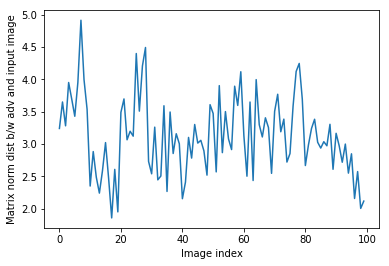

In [17]:
dev_nt=np.zeros(100)
for i in range(100):
    dev_nt[i]=np.linalg.norm(np.abs(adv_nt[i,:,:,0]-adv_inputs[i,:,:,0]))
plt.plot(dev_nt)
plt.xlabel('Image index')
plt.ylabel('Matrix norm dist b/w adv and input image')

In [18]:
len(np.where(dev_nt<0.01)[0])

0

In [19]:
model.predict_classes(adv_inputs)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [20]:
model.predict_classes(adv_nt)

array([5, 2, 9, 9, 2, 8, 2, 9, 6, 9, 8, 7, 8, 3, 4, 7, 8, 7, 2, 7, 3, 1,
       1, 1, 3, 7, 1, 7, 7, 7, 8, 9, 5, 5, 8, 8, 8, 5, 7, 5, 9, 9, 7, 9,
       9, 2, 9, 9, 9, 9, 6, 3, 9, 8, 9, 9, 9, 3, 9, 9, 0, 5, 4, 5, 5, 0,
       9, 4, 5, 5, 9, 9, 9, 2, 2, 2, 5, 2, 9, 4, 2, 5, 3, 3, 3, 9, 9, 3,
       5, 3, 5, 4, 4, 4, 4, 4, 5, 8, 8, 4])

In [21]:
(model.predict_classes(adv_nt)==model.predict_classes(adv_inputs)).sum()

0

In [22]:
np.save('adv_cw_nontargeted88_model9868.npy',adv_nt)

# F-MNIST transfer learning here:

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        4160      
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 128)         295040    
_________________________________________________________________
activation_2 (Activation)    (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 128)         409728    
_________________________________________________________________
activation_3 (Activation)    (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
__________

#  Fashion-MNIST dataset:

## Label	Description :
 - 0:	T-shirt/top
 - 1	Trouser
 - 2	Pullover
 - 3	Dress
 - 4	Coat
 - 5	trouser
 - 6	Shirt
 - 7	tshirt
 - 8	Bag
 - 9	Ankle boot
 
 
 Source: github.com/zalandoresearch/fashion-mnist

2


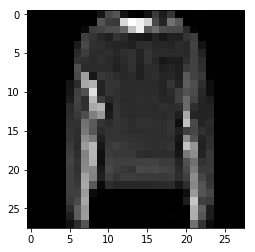

In [24]:
import os
import sys

sys.path.append(os.path.join(os.getcwd(),'fashion_mnist'))
from utils import mnist_reader
#(Vishal) changed test to train
X_train_vec, y_train_vec = mnist_reader.load_mnist('data/fashion', kind='train')
X_test_vec, y_test_vec = mnist_reader.load_mnist('data/fashion', kind='t10k')
#(Vishal) changed test to train
X_train_vec = X_train_vec.astype('float32')
X_test_vec = X_test_vec.astype('float32')
#(Vishal) changed test to train
X_train_vec /= 255
X_test_vec /= 255
from keras.utils import np_utils
#(Vishal) changed test to train
X_train_f=X_train_vec.reshape(60000,28,28,1)
X_test_f=X_test_vec.reshape(10000,28,28,1)
#(Vishal) changed test to train
Y_train_f=np_utils.to_categorical(y_train_vec, num_classes=10)
Y_test_f=np_utils.to_categorical(y_test_vec, num_classes=10)
#Let's display a tshirt:

%matplotlib inline
plt.imshow(X_test_f[243,:,:,0],cmap='gray')
print(np.argmax(Y_test_f[243]))
nb_classes=10

In [25]:
from sklearn.manifold import TSNE

Text(0.5,1,'2D t-SNE plot of the 128-D deep features (Test)')

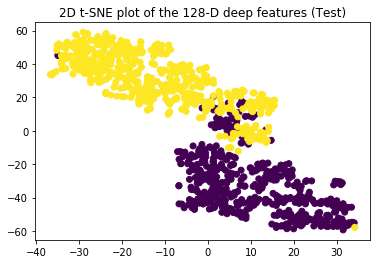

In [26]:
ind_tshirt=np.where(y_test_vec==0)[0][0:600]
ind_trouser=np.where(y_test_vec==1)[0][0:600]
X_tshirt=X_test_f[ind_tshirt]
X_trouser=X_test_f[ind_trouser]
#(Vishal) changed test to train
X_tshirt_train=X_tshirt[0:500]
#(Vishal) changed test to train
X_trouser_train=X_trouser[0:500]
X_tshirt_test=X_tshirt[500:]
X_trouser_test=X_trouser[500:]
#(Vishal) changed test to train
X_tt_train=np.vstack([X_trouser_train,X_tshirt_train])
X_tt_test=np.vstack([X_trouser_test,X_tshirt_test])
#(Vishal) changed layer index to match the new model designed (cnn_keras)
get_3rd_layer_output = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[6].output])
#(Vishal) changed test to train
X_tt_train_feat=get_3rd_layer_output([X_tt_train, 0])[0]
#(Vishal) changed test to train
X_tt_embedded_train = TSNE(n_components=2,perplexity=25).fit_transform(X_tt_train_feat)
#(Vishal) changed test to train
y_tt_train=np.zeros(1000)
#(Vishal) changed test to train
y_tt_train[500:]=1
#(Vishal) changed test to train
plt.scatter(X_tt_embedded_train[:,0],X_tt_embedded_train[:,1],c=y_tt_train)
plt.title('2D t-SNE plot of the 128-D deep features (Test)')

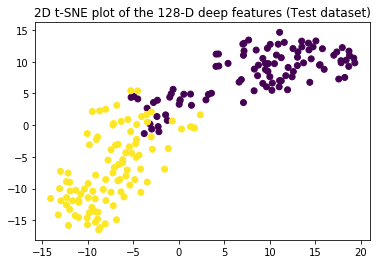

In [27]:
#(Vishal) repeating code, to obtain same information
#ind_tshirt=np.where(y_test_vec==0)[0][0:600]
#ind_trouser=np.where(y_test_vec==1)[0][0:600]
#X_tshirt=X_test_f[ind_tshirt]
#X_trouser=X_test_f[ind_trouser]
#X_tshirt_test=X_tshirt[0:500]
#X_trouser_test=X_trouser[0:500]
#X_tshirt_test=X_tshirt[500:]
#X_trouser_test=X_trouser[500:]
#X_tt_test=np.vstack([X_trouser_test,X_tshirt_test])
#X_tt_test=np.vstack([X_trouser_test,X_tshirt_test])

get_3rd_layer_output = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[6].output])
#(Vishal) This time we keep it as test
X_tt_test_feat=get_3rd_layer_output([X_tt_test, 0])[0]
X_tt_embedded_test = TSNE(n_components=2,perplexity=25).fit_transform(X_tt_test_feat)
y_tt_test=np.zeros(200)
y_tt_test[100:]=1
plt.scatter(X_tt_embedded_test[:,0],X_tt_embedded_test[:,1],c=y_tt_test)
plt.title('2D t-SNE plot of the 128-D deep features (Test dataset)')
plt.show()

In [28]:
X_tt_test_feat[:,0]

array([0.5503826 , 0.        , 0.13611422, 0.42266604, 0.        ,
       1.0148538 , 0.5526203 , 1.0164927 , 1.3722296 , 0.13073052,
       0.6968076 , 0.88188493, 0.11200359, 0.6738504 , 1.001497  ,
       0.22576524, 0.7339825 , 0.4179108 , 0.35899723, 0.44777897,
       0.06866062, 0.26955017, 0.3413568 , 0.        , 0.6425289 ,
       0.4386805 , 0.        , 0.46918678, 0.00923382, 0.3209905 ,
       0.6301681 , 0.7641543 , 0.        , 0.38282633, 0.5324605 ,
       0.8274627 , 0.27822343, 0.        , 0.8997735 , 1.0458293 ,
       0.        , 0.        , 0.29673737, 0.5990784 , 0.3504678 ,
       1.064376  , 0.6318039 , 0.        , 0.32631373, 0.6818948 ,
       1.7584597 , 1.4237841 , 0.        , 0.        , 0.        ,
       0.        , 0.31165895, 0.22844811, 0.34390315, 0.9910431 ,
       1.0210991 , 0.27690947, 0.49062014, 1.2808709 , 0.6305193 ,
       0.6035753 , 0.74643505, 0.        , 0.6980756 , 0.        ,
       0.24085857, 0.4860042 , 0.15338975, 0.        , 0.57384

In [29]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
clf = SVC( kernel='linear')
#(Vishal) changed test to train
clf.fit(X_tt_train_feat, y_tt_train) 
y_pred_svc=clf.predict(X_tt_test_feat)
confusion_matrix(y_tt_test, y_pred_svc)

array([[99,  1],
       [ 3, 97]])

Text(0,0.5,'Counts')

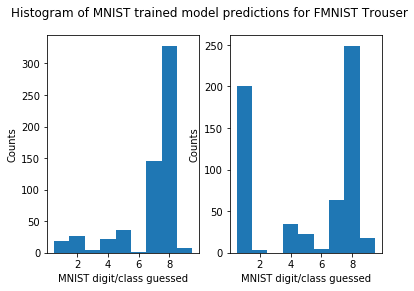

In [30]:
plt.figure(2)
plt.subplot(121)
plt.hist(model.predict_classes(X_tshirt),bins=np.arange(0.5,10.5))
plt.xlabel('MNIST digit/class guessed')
plt.ylabel('Counts')
plt.subplot(122)
plt.hist(model.predict_classes(X_trouser),bins=np.arange(0.5,10.5))
plt.xlabel('MNIST digit/class guessed')
plt.suptitle('Histogram of MNIST trained model predictions for FMNIST Trouser')
plt.ylabel('Counts')

In [31]:
model.predict_classes(X_test[0:6,:,:,:])
#sess.run(preds, feed_dict={x: X_test[0:6,:,:,:]}).argmax(-1)

array([7, 2, 1, 0, 4, 1])

In [32]:
X_tt_test.shape

(200, 28, 28, 1)

(-0.5, 27.5, 27.5, -0.5)

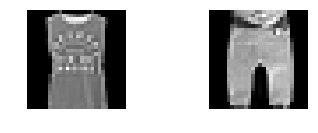

In [33]:
plt.subplot(2,2,1)
plt.imshow(X_tt_test[141,:,:,0],cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(X_tt_test[41,:,:,0],cmap='gray')
plt.axis('off')

# Generate un-targeted adversarial examples for the 2-class FMNIST problem:

In [34]:

cw = CarliniWagnerL2(model_wrap, back='tf', sess=sess)
#(Vishal) Changed max_iterations to test if the code runs (takes too long for original values)
cw_params = {'binary_search_steps': 1,
             'y_target': None,
             'max_iterations':20,#10000,
             'learning_rate': 0.9,
             'batch_size':1000,
             'initial_const':0.5,
            'clip_min' :0,
            'clip_max':1}

X_tt_train_adv = cw.generate_np(X_tt_train, **cw_params)
#(Vishal) Changed max_iterations to test if the code runs (takes too long for original values)
cw = CarliniWagnerL2(model_wrap, back='tf', sess=sess)
cw_params = {'binary_search_steps': 1,
             'y_target': None,
             'max_iterations':20,#10000,
             'learning_rate': 0.9,
             'batch_size':200,
             'initial_const':0.5,
            'clip_min' :0,
            'clip_max':1}
X_tt_test_adv = cw.generate_np(X_tt_test, **cw_params)

[INFO 2018-02-18 20:48:44,620 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-02-18 20:48:50,464 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-02-18 20:48:50,577 cleverhans]   Binary search step 0 of 1
[DEBUG 2018-02-18 20:48:56,227 cleverhans]     Iteration 0 of 20: loss=442 l2=0 f=-0.185
[DEBUG 2018-02-18 20:49:07,542 cleverhans]     Iteration 2 of 20: loss=6.34e+03 l2=6.34 f=-0.165
[DEBUG 2018-02-18 20:49:07,543 cleverhans]     Failed to make progress; stop early
[DEBUG 2018-02-18 20:49:07,562 cleverhans]   Successfully generated adversarial examples on 1000 of 1000 instances.
[DEBUG 2018-02-18 20:49:07,564 cleverhans]    Mean successful distortion: 5.589
[INFO 2018-02-18 20:49:07,578 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-02-18 20:49:10,053 cleverhans] Running CWL2 attack on instance 0 of 200
[DEBUG 2018-02-18 20:49:10,116 cleverhans]   Binary search step 0 of 1
[DEBUG 2018-02-18 20:49:11,366 cleverhan

(-0.5, 27.5, 27.5, -0.5)

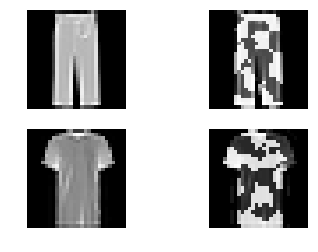

In [35]:
plt.subplot(2,2,1)
#(Vishal) changed test to train
plt.imshow(X_tt_train[243,:,:,0],cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
#(Vishal) changed test to train
plt.imshow(X_tt_train_adv[243,:,:,0],cmap='gray')
plt.axis('off')

plt.subplot(2,2,3)
#(Vishal) changed test to train
plt.imshow(X_tt_train[543,:,:,0],cmap='gray')
plt.axis('off')
plt.subplot(2,2,4)
#(Vishal) changed test to train
plt.imshow(X_tt_train_adv[543,:,:,0],cmap='gray')
plt.axis('off')

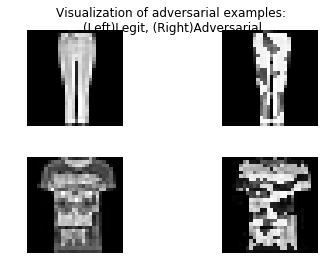

In [36]:
plt.subplot(2,2,1)
plt.imshow(X_tt_test[43,:,:,0],cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(X_tt_test_adv[43,:,:,0],cmap='gray')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(X_tt_test[143,:,:,0],cmap='gray')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(X_tt_test_adv[143,:,:,0],cmap='gray')
plt.axis('off')
plt.suptitle('Visualization of adversarial examples: \n(Left)Legit, (Right)Adversarial')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Confirming that the damage is indeed done

In [37]:
(model.predict_classes(X_tt_train)==model.predict_classes(X_tt_train_adv)).sum()

0

In [38]:
(model.predict_classes(X_tt_test)==model.predict_classes(X_tt_test_adv)).sum()

0

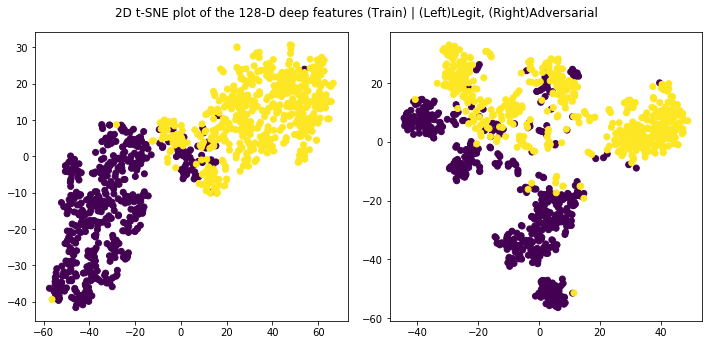

In [39]:
#(Vishal) repeated for train (previously only test was present)
#(Vishal) changed test to train (was commented out originally)
X_tt_train_feat=get_3rd_layer_output([X_tt_train, 0])[0]
X_tt_embedded_train = TSNE(n_components=2,perplexity=25).fit_transform(X_tt_train_feat)
y_tt_train=np.zeros(1000)
y_tt_train[500:]=1
plt.figure(figsize=(10,5))
plt.subplot(121)
#(Vishal) changed test to train
plt.scatter(X_tt_embedded_train[:,0],X_tt_embedded_train[:,1],c=y_tt_train)


#(Vishal) changed test to train (was commented out originally)
X_tt_train_feat_adv=get_3rd_layer_output([X_tt_train_adv, 0])[0]
X_tt_embedded_train_adv = TSNE(n_components=2,perplexity=25).fit_transform(X_tt_train_feat_adv)
y_tt_train=np.zeros(1000)
y_tt_train[500:]=1
plt.subplot(122)
#(Vishal) changed test to train
plt.scatter(X_tt_embedded_train_adv[:,0],X_tt_embedded_train_adv[:,1],c=y_tt_train)

plt.suptitle('2D t-SNE plot of the 128-D deep features (Train) | (Left)Legit, (Right)Adversarial')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

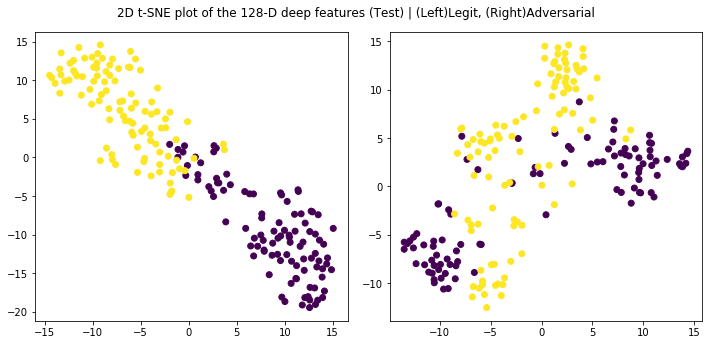

In [40]:
X_tt_test_feat=get_3rd_layer_output([X_tt_test, 0])[0]
X_tt_embedded_test = TSNE(n_components=2,perplexity=25).fit_transform(X_tt_test_feat)
y_tt_test=np.zeros(200)
y_tt_test[100:]=1
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(X_tt_embedded_test[:,0],X_tt_embedded_test[:,1],c=y_tt_test)



X_tt_test_feat_adv=get_3rd_layer_output([X_tt_test_adv, 0])[0]
X_tt_embedded_test_adv = TSNE(n_components=2,perplexity=25).fit_transform(X_tt_test_feat_adv)
y_tt_test=np.zeros(200)
y_tt_test[100:]=1
plt.subplot(122)
plt.scatter(X_tt_embedded_test_adv[:,0],X_tt_embedded_test_adv[:,1],c=y_tt_test)

plt.suptitle('2D t-SNE plot of the 128-D deep features (Test) | (Left)Legit, (Right)Adversarial')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])


In [41]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
clf = SVC( kernel='rbf')
#(Vishal) changed test to train
clf.fit(X_tt_train_feat, y_tt_train) 
y_pred_svc=clf.predict(X_tt_test_feat)
print(confusion_matrix(y_tt_test, y_pred_svc))

clf = SVC( kernel='linear')
#(Vishal) changed test to train
clf.fit(X_tt_train_feat, y_tt_train) 
y_pred_svc=clf.predict(X_tt_test_feat)
confusion_matrix(y_tt_test, y_pred_svc)

[[ 91   9]
 [  0 100]]


array([[99,  1],
       [ 3, 97]])

In [42]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
clf = SVC( kernel='rbf')
#(Vishal) changed test to train
clf.fit(X_tt_train_feat_adv, y_tt_train) 
y_pred_svc=clf.predict(X_tt_test_feat_adv)
print(confusion_matrix(y_tt_test, y_pred_svc))

clf = SVC( kernel='linear')
#(Vishal) changed test to train
clf.fit(X_tt_train_feat_adv, y_tt_train) 
y_pred_svc=clf.predict(X_tt_test_feat_adv)
confusion_matrix(y_tt_test, y_pred_svc)

[[91  9]
 [ 4 96]]


array([[89, 11],
       [ 5, 95]])

In [45]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import pydot
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

I modified the code, to run from start to finish. I have added comments to indicate where I have made changes. They begin with (Vishal) to easily identify them. 

Since I did not have access to run on GPUs, i reduced the number of iterations to test it (also commented in the code)